In [84]:
# Imports
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [85]:
if (os.environ.get('DB_TYPE') == None):
    from dotenv import load_dotenv
    from config.definitions import ROOT_DIR
    load_dotenv(os.path.join(ROOT_DIR, 'config', 'conf', '.env'))

In [86]:
# Database Credentials

db_type = os.environ.get("DB_TYPE")
user = os.environ.get('DB_USER')
pswd = os.environ.get('DB_PASS')
host = os.environ.get('DB_HOST')
db_name = os.environ.get('DB_NAME')
print(db_type)

postgresql


In [4]:
engine = create_engine(f'{db_type}+psycopg2://{user}:{pswd}@{host}/{db_name}', echo=False)

In [5]:
conn = engine.connect()

In [6]:
query = "SELECT table_name FROM information_schema.tables\
        WHERE table_schema = 'public'"
exec = conn.execute(query)

for table in exec.fetchall():
    print(table)

('vitrine_hm',)
('vitrine_marcy',)


In [7]:
query_h = """SELECT * FROM vitrine_hm"""
query_m = """SELECT * FROM vitrine_marcy"""

In [8]:
df_raw_hm = pd.read_sql(query_h, con=conn)
df_raw_macys = pd.read_sql(query_m, con=conn)

# H&M

In [9]:
df_raw_hm.head()

,product_id,style_id,color_id,product_type,product_name,color_name,fit,price,model_size,model_height,cotton,rayon,lyocell,polyester,spandex,elastomultiester,scrap_datetime
0,1024256001,1024256,1,men_jeans_slim,slim_jeans,black,slim_fit,24.99,33/32,180.0,0.99,0.0,0.0,0.65,0.01,0.0,2023-01-30 21:06:18
1,1024256002,1024256,2,men_jeans_slim,slim_jeans,light_denim_blue,slim_fit,24.99,None,NaN,0.99,0.0,0.0,0.65,0.01,0.0,2023-01-30 21:06:18
2,1024256003,1024256,3,men_jeans_slim,slim_jeans,light_denim_blue,slim_fit,24.99,33/32,180.0,0.99,0.0,0.0,0.65,0.01,0.0,2023-01-30 21:06:18
3,1024256004,1024256,4,men_jeans_slim,slim_jeans,denim_blue,slim_fit,24.99,None,NaN,0.99,0.0,0.0,0.65,0.01,0.0,2023-01-30 21:06:18
4,1024256005,1024256,5,men_jeans_slim,slim_jeans,dark_blue,slim_fit,24.99,31/32,183.0,0.99,0.0,0.0,0.65,0.01,0.0,2023-01-30 21:06:18


In [10]:
df_hm1 = df_raw_hm.copy()

### Data Dimension 

In [11]:
print('Number of rows:', df_hm1.shape[0])
print('Number of columns:', df_hm1.shape[1])

Number of rows: 12101
Number of columns: 17


### Data types


In [12]:
df_hm1.dtypes

product_id            int64
style_id              int64
color_id              int64
product_type         object
product_name         object
color_name           object
fit                  object
price               float64
model_size           object
model_height        float64
cotton              float64
rayon               float64
lyocell             float64
polyester           float64
spandex             float64
elastomultiester    float64
scrap_datetime       object
dtype: object

In [13]:
df_hm1['scrap_datetime'] = pd.to_datetime(df_hm1['scrap_datetime'])

### Missing data

In [14]:
df_hm1.isna().sum()

product_id             0
style_id               0
color_id               0
product_type           0
product_name           0
color_name             0
fit                    0
price                  0
model_size          6488
model_height        5720
cotton                 0
rayon                  0
lyocell                0
polyester              0
spandex                0
elastomultiester       0
scrap_datetime         0
dtype: int64

In [15]:
df_hm1.isna().sum()/df_hm1.shape[0]*100

product_id           0.000000
style_id             0.000000
color_id             0.000000
product_type         0.000000
product_name         0.000000
color_name           0.000000
fit                  0.000000
price                0.000000
model_size          53.615404
model_height        47.268821
cotton               0.000000
rayon                0.000000
lyocell              0.000000
polyester            0.000000
spandex              0.000000
elastomultiester     0.000000
scrap_datetime       0.000000
dtype: float64

### Handling missing data

Model size and height won't be necessary for analysis. So these features will be dropped.

In [16]:
df_hm2 = df_hm1.drop(columns=['model_size', 'model_height'])

### 1.5 Data Description


In [17]:
df_num = df_hm2.select_dtypes(include=['float64', 'int64']).drop(['product_id', 'style_id', 'color_id'], axis=1)
cat_attributes = df_hm2.select_dtypes(exclude=['float64', 'int64','datetime64[ns]'])

##### 1.5.1 Numeric

In [18]:
# Central tendency and Dispersion
summary  = df_num.describe(percentiles=[0.01,0.25,0.5,0.75,0.99]).T
summary['skew'] = df_num.skew()
summary['kurtosis'] = df_num.kurtosis()
summary


,count,mean,std,min,1%,25%,50%,75%,99%,max,skew,kurtosis
price,12101.0,36.151474,7.634201,19.99,19.99,29.99,39.99,39.99,49.99,49.99,-0.531708,-0.444905
cotton,12101.0,0.974980,0.058115,0.35,0.77,0.98,0.99,1.00,1.00,1.00,-2.958518,8.453423
rayon,12101.0,0.000752,0.011881,0.00,0.00,0.00,0.00,0.00,0.00,0.50,21.111226,623.679700
lyocell,12101.0,0.002537,0.037214,0.00,0.00,0.00,0.00,0.00,0.00,0.55,14.605547,211.409211
polyester,12101.0,0.380097,0.331351,0.00,0.00,0.00,0.65,0.65,1.00,1.00,-0.104156,-1.731018
spandex,12101.0,0.009183,0.007540,0.00,0.00,0.00,0.01,0.01,0.02,0.02,0.135785,-1.231780
elastomultiester,12101.0,0.003156,0.015977,0.00,0.00,0.00,0.00,0.00,0.09,0.09,4.883892,21.955914


## Passo 2 - Feature Engineering

In [30]:
df_hm2['year'] = df_hm2['scrap_datetime'].dt.year
df_hm2['month'] = df_hm2['scrap_datetime'].dt.month
df_hm2['day'] = df_hm2['scrap_datetime'].dt.day
df_hm2['week'] = df_hm2['scrap_datetime'].dt.isocalendar().week
df_hm2['week_day'] = df_hm2['scrap_datetime'].dt.weekday
df_hm2['hour'] = df_hm2['scrap_datetime'].dt.hour
df_hm2['minute'] = df_hm2['scrap_datetime'].dt.minute
df_hm2['month_day'] = df_hm2['scrap_datetime'].dt.strftime('%m-%d')

In [31]:
df_hm2.head()

,product_id,style_id,color_id,product_type,product_name,color_name,fit,price,cotton,rayon,...,elastomultiester,scrap_datetime,year,month,day,week,week_day,hour,minute,month_day
0,1024256001,1024256,1,men_jeans_slim,slim_jeans,black,slim_fit,24.99,0.99,0.0,...,0.0,2023-01-30 21:06:18,2023,1,30,5,0,21,6,01-30
1,1024256002,1024256,2,men_jeans_slim,slim_jeans,light_denim_blue,slim_fit,24.99,0.99,0.0,...,0.0,2023-01-30 21:06:18,2023,1,30,5,0,21,6,01-30
2,1024256003,1024256,3,men_jeans_slim,slim_jeans,light_denim_blue,slim_fit,24.99,0.99,0.0,...,0.0,2023-01-30 21:06:18,2023,1,30,5,0,21,6,01-30
3,1024256004,1024256,4,men_jeans_slim,slim_jeans,denim_blue,slim_fit,24.99,0.99,0.0,...,0.0,2023-01-30 21:06:18,2023,1,30,5,0,21,6,01-30
4,1024256005,1024256,5,men_jeans_slim,slim_jeans,dark_blue,slim_fit,24.99,0.99,0.0,...,0.0,2023-01-30 21:06:18,2023,1,30,5,0,21,6,01-30


In [48]:
df_aux_mean = df_hm2[['product_type', 'price']].groupby('product_type').mean().reset_index()
df_aux_min = df_hm2[['product_type', 'price']].groupby('product_type').min().reset_index()
df_aux_max = df_hm2[['product_type', 'price']].groupby('product_type').max().reset_index()

<AxesSubplot: xlabel='product_type', ylabel='price'>

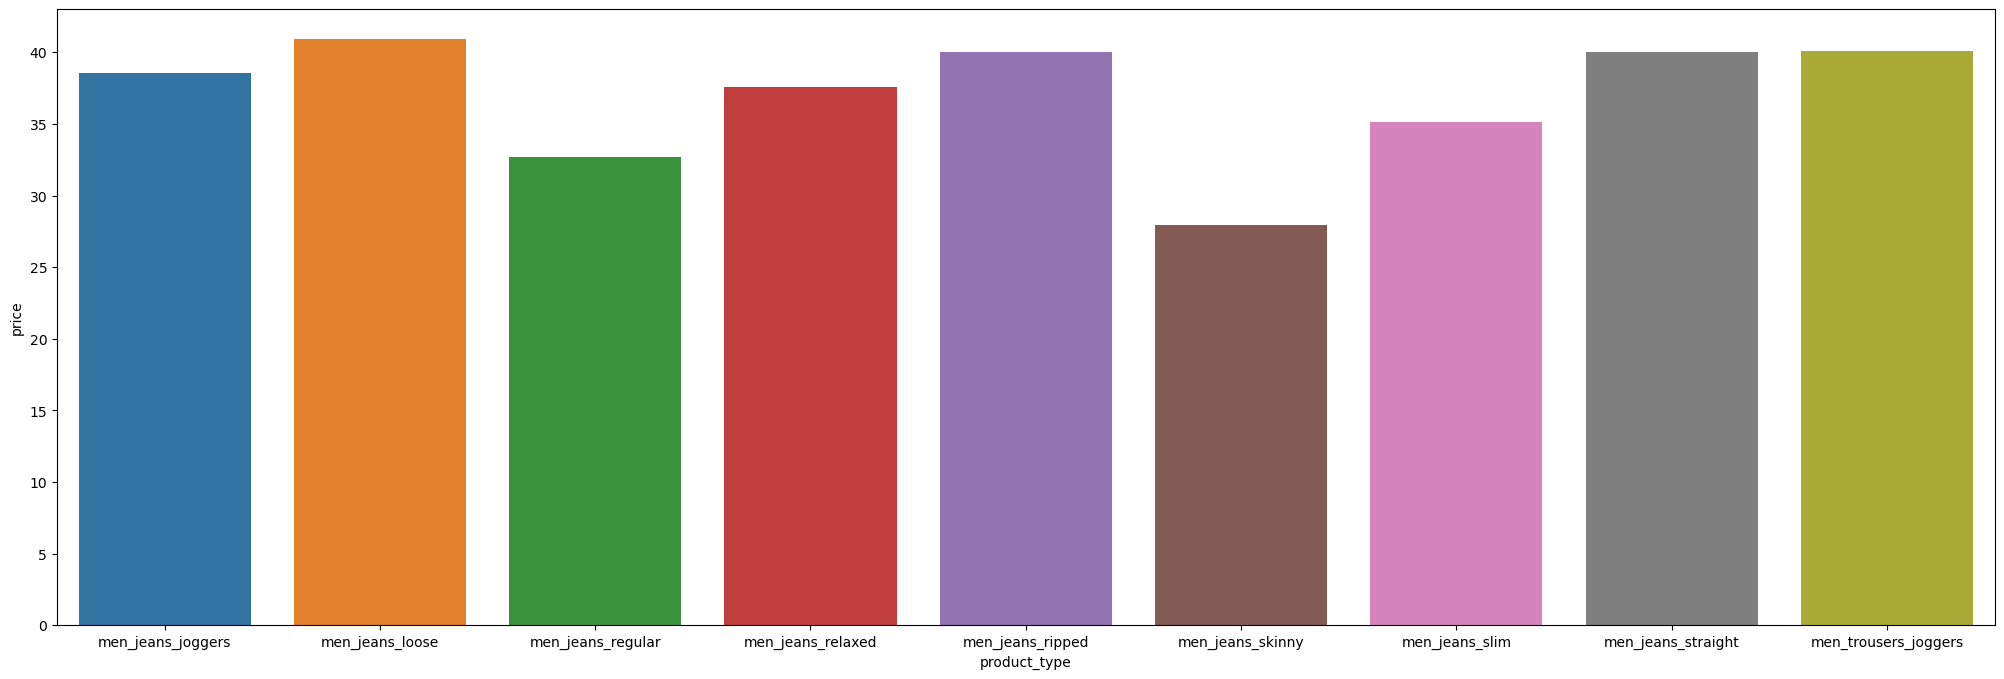

In [49]:
plt.figure(figsize=(25, 8))
sns.barplot(data=df_aux_mean, x='product_type', y='price')

<AxesSubplot: xlabel='product_type', ylabel='price'>

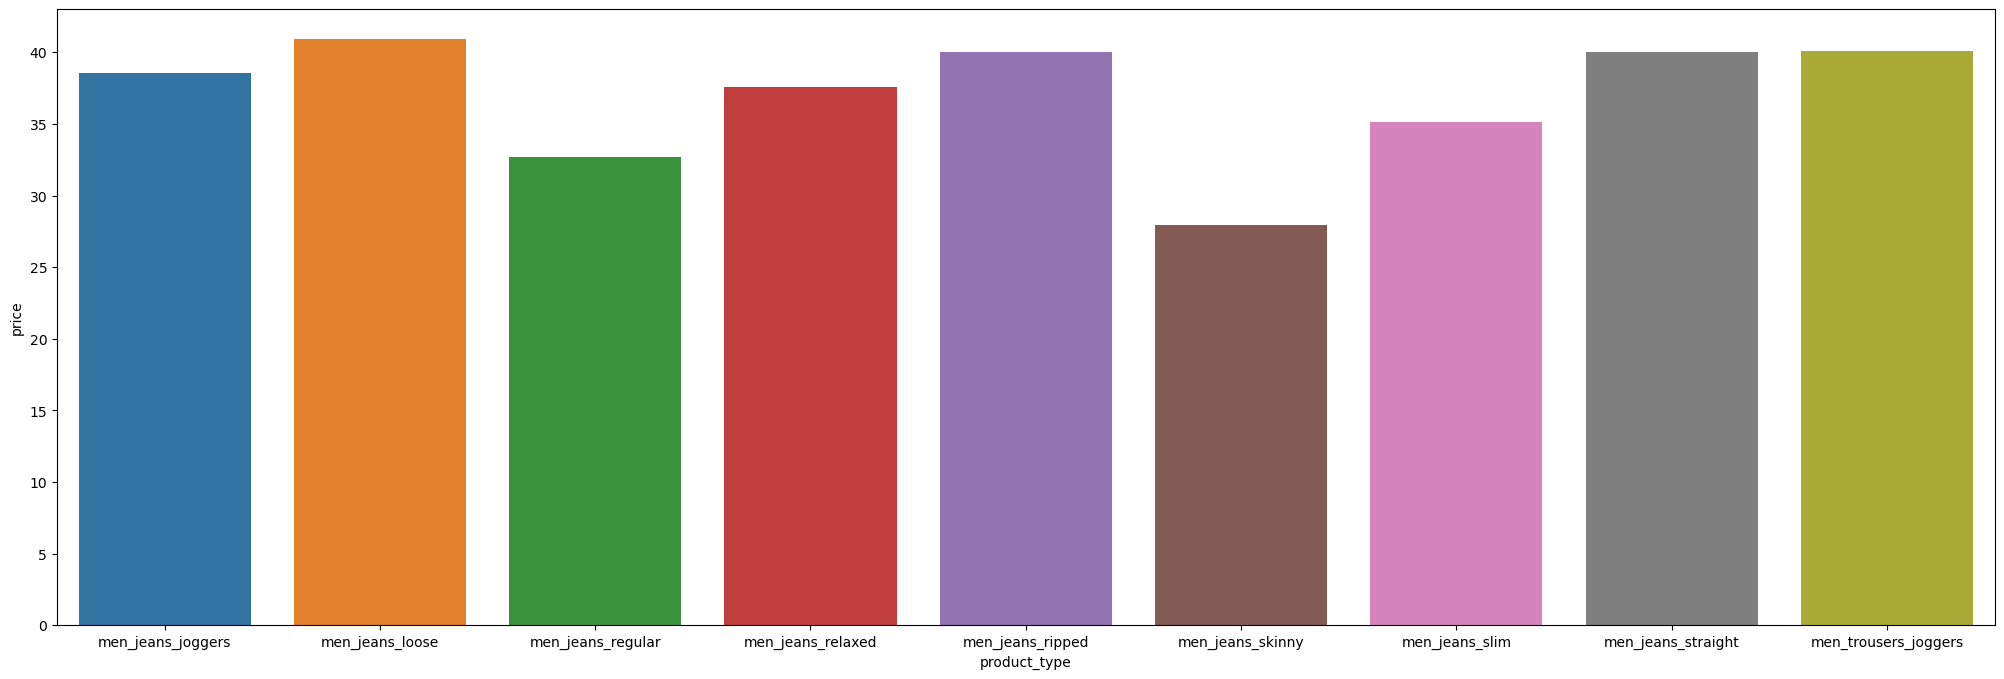

In [ ]:
plt.figure(figsize=(25, 8))
sns.barplot(data=df_aux_min, x='product_type', y='price')

<AxesSubplot: xlabel='product_type', ylabel='price'>

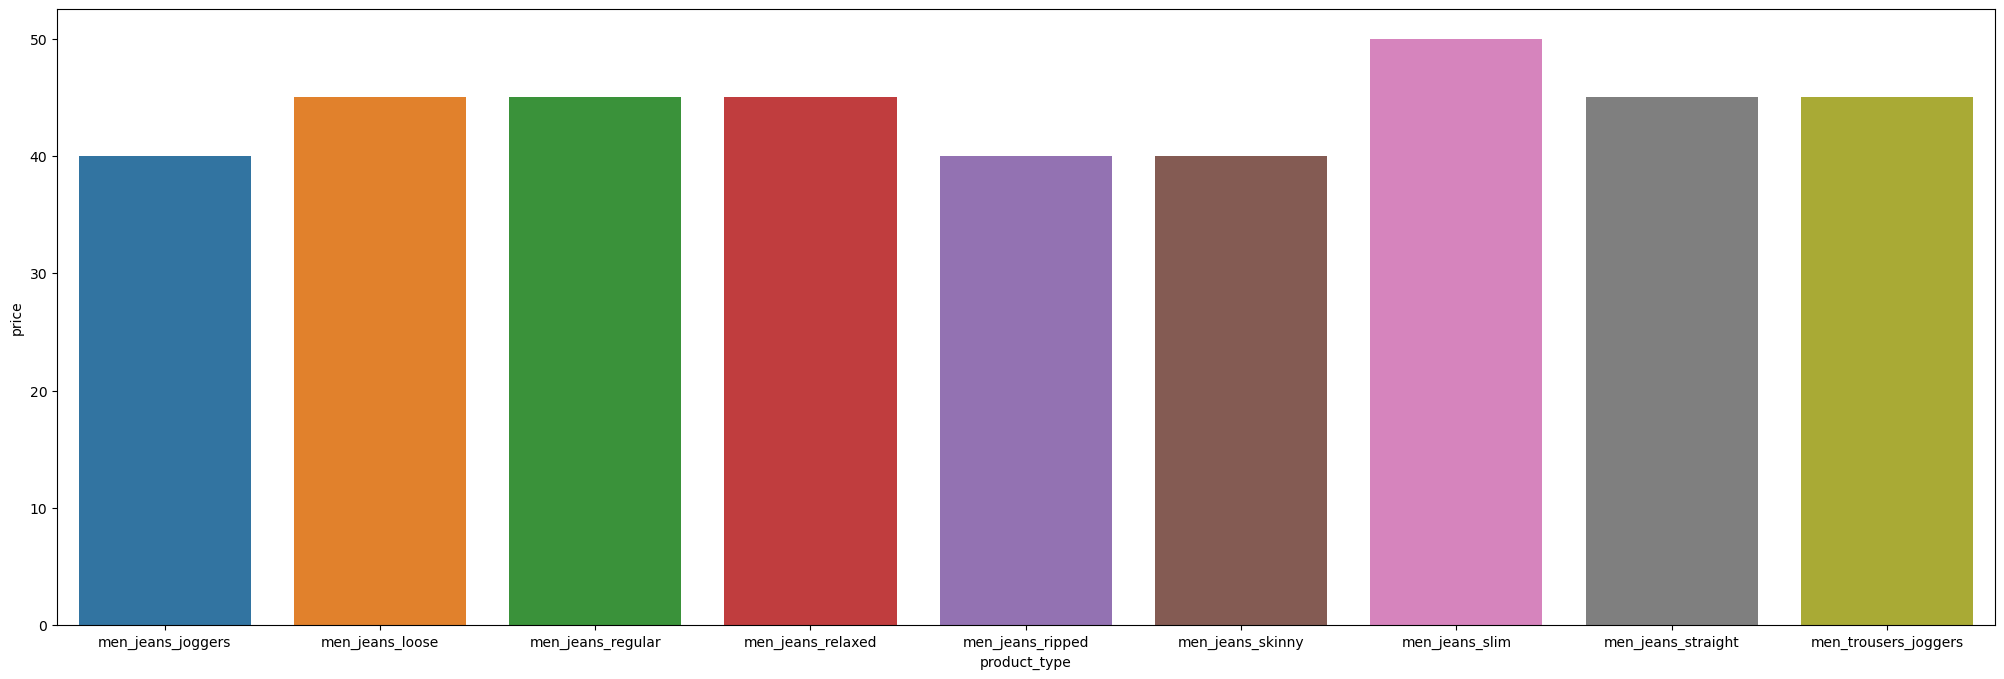

In [51]:
plt.figure(figsize=(25, 8))
sns.barplot(data=df_aux_max, x='product_type', y='price')

In [41]:
df_hm2['product_name'].value_counts()

regular_jeans                     1807
skinny_jeans                      1764
relaxed_jeans                     1483
slim_jeans                        1368
loose_jeans                       1318
hybrid_regular_tapered_joggers     597
slim_tapered_jeans                 513
freefit®_slim_jeans                456
skinny_crop_jeans                  342
regular_tapered_crop_jeans         336
hybrid_regular_jeans               285
slim_tapered_cropped_jeans         260
essentials_no_2:_the_jeans         228
loose_bootcut_jeans                228
regular_crop_jeans                 171
relaxed_pull-on_jeans              171
relaxed_denim_joggers              169
baggy_jeans                        153
slim_flared_jeans                  114
relaxed_worker_jeans               114
2-pack_slim_jeans                  114
regular_bootcut_jeans              108
loose_pull-on_jeans                  2
Name: product_name, dtype: int64

# Macy's

In [52]:
df_raw_macys.head()

,product_id,style_id,color_id,product_type,product_name,color_name,fit,price,size,composition,material_1,material_2,material_3,material_4,material_5,scrap_datetime
0,2834585,32808,6823802.0,slim,men_512_slim_taper_fit_jeans,charred_marshmallow,taper_fit,79.5,28/30,cotton/elastane,cotton,elastane,None,None,None,2023-01-30 20:32:01
1,2834585,32808,2383464.0,slim,men_512_slim_taper_fit_jeans,dark_hollow_waterless,taper_fit,79.5,28/30,cotton/elastane,cotton,elastane,None,None,None,2023-01-30 20:32:01
2,2834585,32808,5365049.0,slim,men_512_slim_taper_fit_jeans,goldenrod,taper_fit,79.5,28/30,cotton/elastane,cotton,elastane,None,None,None,2023-01-30 20:32:01
3,2834585,32808,5584522.0,slim,men_512_slim_taper_fit_jeans,native_cali,taper_fit,79.5,28/30,cotton/elastane,cotton,elastane,None,None,None,2023-01-30 20:32:01
4,2834585,32808,2713262.0,slim,men_512_slim_taper_fit_jeans,sin_city_waterless,taper_fit,79.5,28/30,cotton/elastane,cotton,elastane,None,None,None,2023-01-30 20:32:01


In [68]:
df_macys1 = df_raw_macys.copy()

### Data Dimension 

In [69]:
print('Number of rows:', df_macys1.shape[0])
print('Number of columns:', df_macys1.shape[1])

Number of rows: 10208
Number of columns: 16


### Data types


In [70]:
df_macys1.dtypes

product_id          int64
style_id            int64
color_id          float64
product_type       object
product_name       object
color_name         object
fit                object
price             float64
size               object
composition        object
material_1         object
material_2         object
material_3         object
material_4         object
material_5         object
scrap_datetime     object
dtype: object

In [71]:
df_macys1['scrap_datetime'] = pd.to_datetime(df_hm1['scrap_datetime'])

### Missing data

In [72]:
df_macys1.isna().sum()

product_id            0
style_id              0
color_id            285
product_type          0
product_name          0
color_name          285
fit                   0
price                 0
size                310
composition           0
material_1            0
material_2          115
material_3         5542
material_4         9510
material_5        10086
scrap_datetime        0
dtype: int64

In [73]:
df_macys1.isna().sum()/df_hm1.shape[0]

product_id        0.000000
style_id          0.000000
color_id          0.023552
product_type      0.000000
product_name      0.000000
color_name        0.023552
fit               0.000000
price             0.000000
size              0.025618
composition       0.000000
material_1        0.000000
material_2        0.009503
material_3        0.457979
material_4        0.785885
material_5        0.833485
scrap_datetime    0.000000
dtype: float64

### Handling missing data

In [74]:
df_macys2 = df_macys1.drop(columns=['size'])

### 1.5 Data Description


In [75]:
df_num = df_macys2.select_dtypes(include=['float64', 'int64']).drop(['product_id', 'style_id', 'color_id'], axis=1)
cat_attributes = df_hm2.select_dtypes(exclude=['float64', 'int64','datetime64[ns]'])

##### 1.5.1 Numeric

In [76]:
# Central tendency and Dispersion
summary  = df_num.describe(percentiles=[0.01,0.25,0.5,0.75,0.99]).T
summary['skew'] = df_num.skew()
summary['kurtosis'] = df_num.kurtosis()
summary


,count,mean,std,min,1%,25%,50%,75%,99%,max,skew,kurtosis
price,10208.0,77.638383,36.563572,15.86,29.7,49.5,69.5,96.0,225.0,240.0,1.788443,4.39571


In [77]:
df_macys2['year'] = df_macys2['scrap_datetime'].dt.year
df_macys2['month'] = df_macys2['scrap_datetime'].dt.month
df_macys2['day'] = df_macys2['scrap_datetime'].dt.day
df_macys2['week'] = df_macys2['scrap_datetime'].dt.isocalendar().week
df_macys2['week_day'] = df_macys2['scrap_datetime'].dt.weekday
df_macys2['hour'] = df_macys2['scrap_datetime'].dt.hour
df_macys2['minute'] = df_macys2['scrap_datetime'].dt.minute
df_macys2['month_day'] = df_macys2['scrap_datetime'].dt.strftime('%m-%d')

In [78]:
df_macys2.head()

,product_id,style_id,color_id,product_type,product_name,color_name,fit,price,composition,material_1,...,material_5,scrap_datetime,year,month,day,week,week_day,hour,minute,month_day
0,2834585,32808,6823802.0,slim,men_512_slim_taper_fit_jeans,charred_marshmallow,taper_fit,79.5,cotton/elastane,cotton,...,None,2023-01-30 21:06:18,2023,1,30,5,0,21,6,01-30
1,2834585,32808,2383464.0,slim,men_512_slim_taper_fit_jeans,dark_hollow_waterless,taper_fit,79.5,cotton/elastane,cotton,...,None,2023-01-30 21:06:18,2023,1,30,5,0,21,6,01-30
2,2834585,32808,5365049.0,slim,men_512_slim_taper_fit_jeans,goldenrod,taper_fit,79.5,cotton/elastane,cotton,...,None,2023-01-30 21:06:18,2023,1,30,5,0,21,6,01-30
3,2834585,32808,5584522.0,slim,men_512_slim_taper_fit_jeans,native_cali,taper_fit,79.5,cotton/elastane,cotton,...,None,2023-01-30 21:06:18,2023,1,30,5,0,21,6,01-30
4,2834585,32808,2713262.0,slim,men_512_slim_taper_fit_jeans,sin_city_waterless,taper_fit,79.5,cotton/elastane,cotton,...,None,2023-01-30 21:06:18,2023,1,30,5,0,21,6,01-30


In [79]:
df_aux_mean = df_macys2[['product_type', 'price']].groupby('product_type').mean().reset_index()
df_aux_min = df_macys2[['product_type', 'price']].groupby('product_type').min().reset_index()
df_aux_max = df_macys2[['product_type', 'price']].groupby('product_type').max().reset_index()

<AxesSubplot: xlabel='product_type', ylabel='price'>

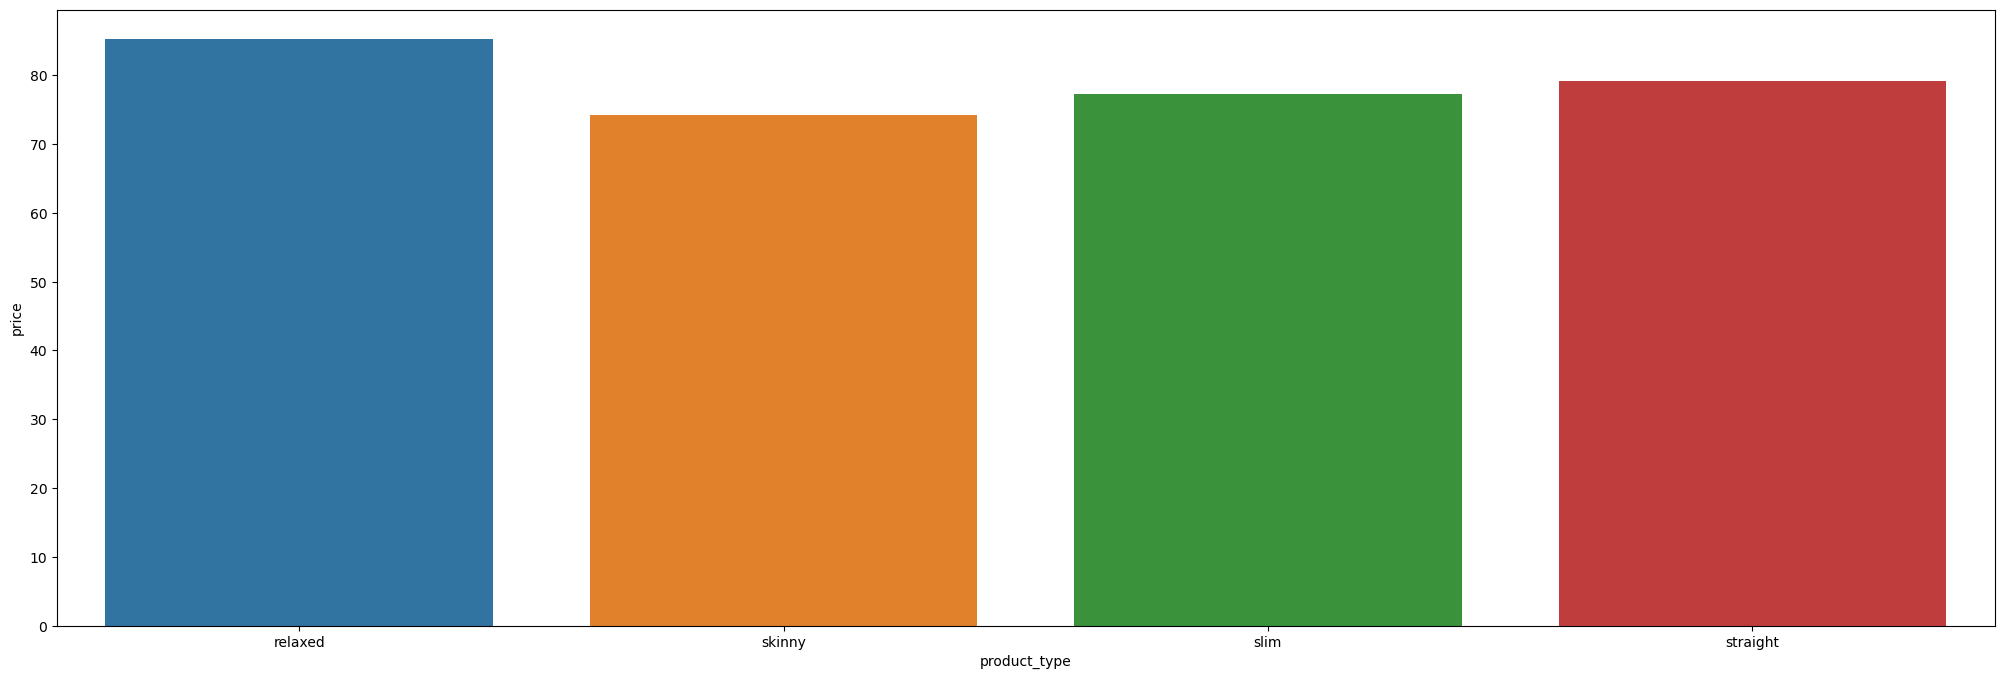

In [80]:
plt.figure(figsize=(25, 8))
sns.barplot(data=df_aux_mean, x='product_type', y='price')

<AxesSubplot: xlabel='product_type', ylabel='price'>

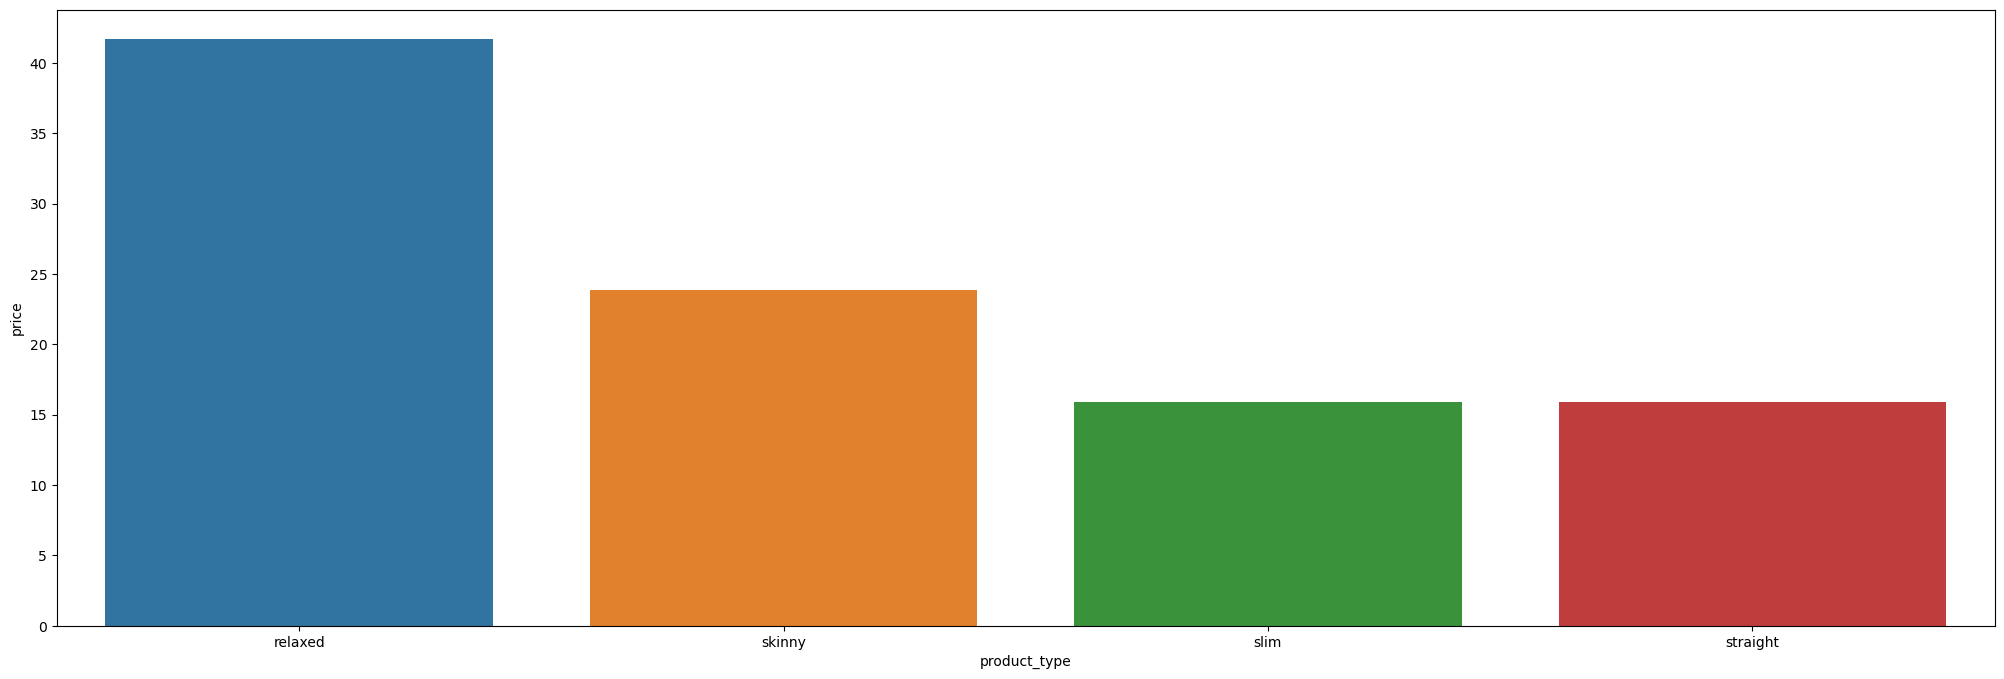

In [83]:
plt.figure(figsize=(25, 8))
sns.barplot(data=df_aux_min, x='product_type', y='price')

<AxesSubplot: xlabel='product_type', ylabel='price'>

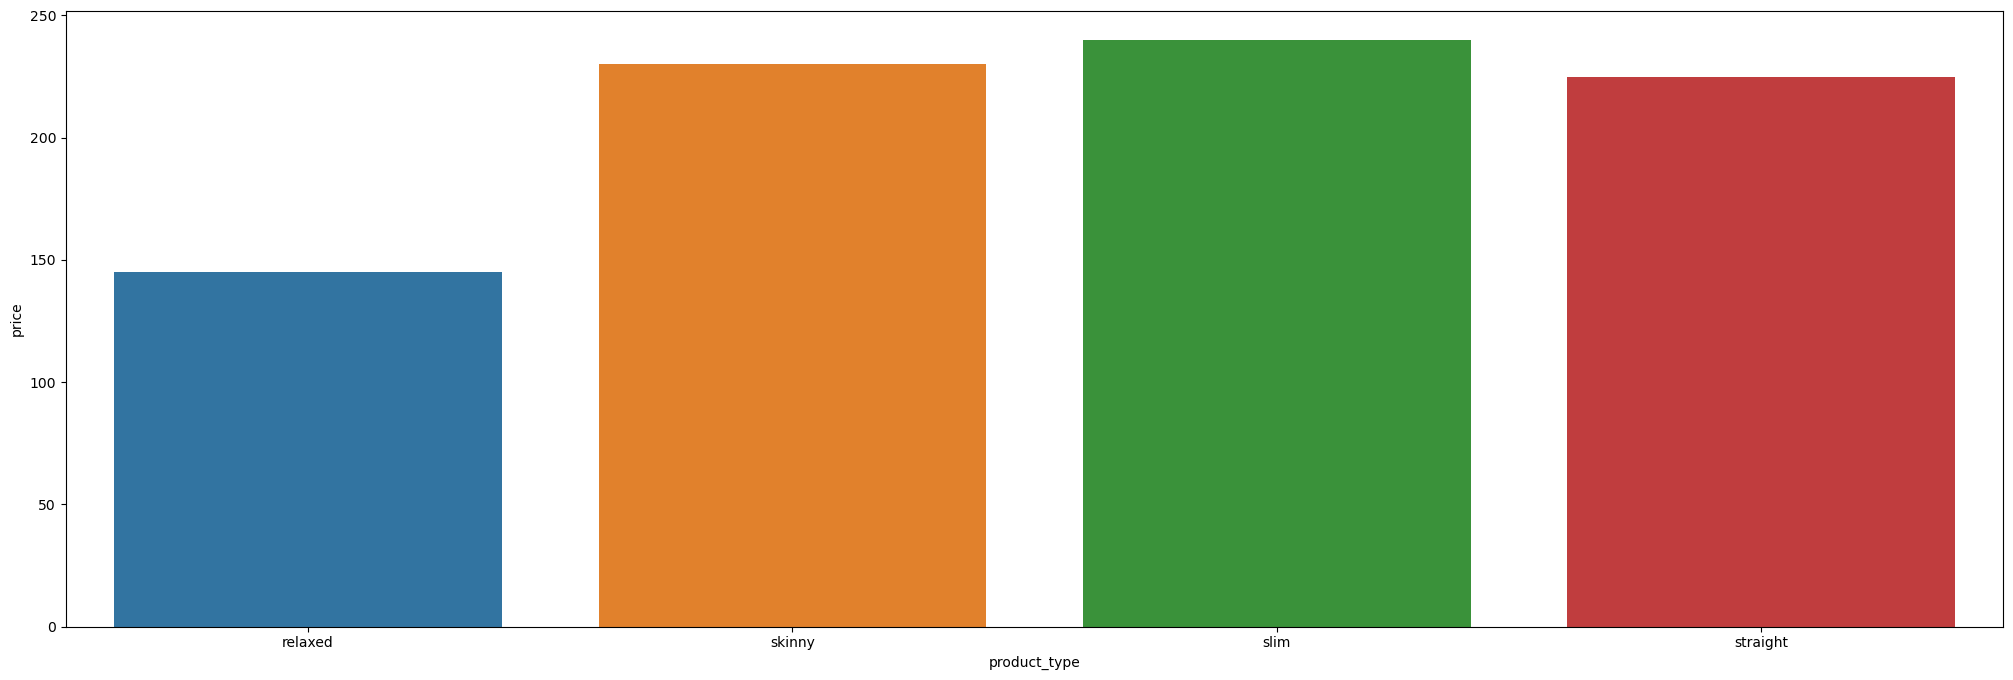

In [82]:
plt.figure(figsize=(25, 8))
sns.barplot(data=df_aux_max, x='product_type', y='price')

In [ ]:
df_hm2['product_name'].value_counts()

regular_jeans                     1807
skinny_jeans                      1764
relaxed_jeans                     1483
slim_jeans                        1368
loose_jeans                       1318
hybrid_regular_tapered_joggers     597
slim_tapered_jeans                 513
freefit®_slim_jeans                456
skinny_crop_jeans                  342
regular_tapered_crop_jeans         336
hybrid_regular_jeans               285
slim_tapered_cropped_jeans         260
essentials_no_2:_the_jeans         228
loose_bootcut_jeans                228
regular_crop_jeans                 171
relaxed_pull-on_jeans              171
relaxed_denim_joggers              169
baggy_jeans                        153
slim_flared_jeans                  114
relaxed_worker_jeans               114
2-pack_slim_jeans                  114
regular_bootcut_jeans              108
loose_pull-on_jeans                  2
Name: product_name, dtype: int64